# Prerequisites

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import importlib
from datetime import datetime, timedelta
import numpy as np

is_on_colab = False

In [2]:
# Optiional: Connect to Google Colab
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    timenow = datetime.now()+timedelta(hours=-7)
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir("/content/drive/MyDrive/Chronical/2024_07/PNC_Capstone")
    is_on_colab = True
else:
    print('Running on Local')
    timenow = datetime.now()
    is_on_colab = False

timenow_str = f"{timenow.hour:02d}{timenow.minute:02d}{timenow.month:02d}{timenow.day:02d}"

Running on Local


In [3]:
import Hypers
importlib.reload(Hypers)
import utils
importlib.reload(utils)
import Trainer
importlib.reload(Trainer)

utils.fix_random_seed(1127)#Hypers.Config.seed)

if is_on_colab:
  Hypers.Config.base_path = os.getcwd()
  Hypers.Config.data_path = os.path.join(Hypers.Config.base_path, "data")
  Hypers.Config.model_path = os.path.join(Hypers.Config.base_path, "model")
  Hypers.Config.log_path = os.path.join(Hypers.Config.base_path, "log")

print(f"{Hypers.Config.base_path=}")
print(f"{Hypers.Config.data_path=}")
print(f"{Hypers.Config.model_path=}")
print(f"{Hypers.Config.log_path=}")

Hypers.Config.base_path='c:\\Users\\Ryo\\Desktop\\PNC_Capstone'
Hypers.Config.data_path='c:\\Users\\Ryo\\Desktop\\PNC_Capstone\\data'
Hypers.Config.model_path='c:\\Users\\Ryo\\Desktop\\PNC_Capstone\\model'
Hypers.Config.log_path='c:\\Users\\Ryo\\Desktop\\PNC_Capstone\\log'


In [4]:
suffix = "US"
window_size = 4

In [5]:
import CompustatExtractor
importlib.reload(CompustatExtractor)
from CompustatExtractor import CompustatExtractor

dataset_path = os.path.join(Hypers.Config.data_path, "WRDS", f"dataset_{suffix}.pkl")
dataset_noCPI_path = os.path.join(Hypers.Config.data_path, "WRDS", f"dataset_{suffix}_noCPI.pkl")

features = CompustatExtractor.process_compustat_features(
	os.path.join(Hypers.Config.data_path, "WRDS", f"features_{suffix}.csv"),
	save=False,
	filestem=f"features_{suffix}",
	add_cpi=True
)

concatenate_features = CompustatExtractor.concatenate_features(features, k=window_size)

ratings = CompustatExtractor.process_compustat_ratings(
	os.path.join(Hypers.Config.data_path, "WRDS", f"ratings_{suffix}.csv"),
	save=False,
	filestem=f"ratings_{suffix}"
)

merged_dict = CompustatExtractor.merge_input_output_dicts(
	concatenate_features,
	ratings,
	save=True,
	filestem=f"dataset_{suffix}"
)


input_dict: 2510
output_dict: 1151
merged_dict: 775


### Data preprocessing

In [29]:
import itertools

preprocessing_options = [
    {"standardize": True, "power_transformation": True},
    {"standardize": True, "power_transformation": False},
    {"standardize": False, "power_transformation": True},
    {"standardize": False, "power_transformation": False},
]

architecture_options = [
    {"dropout": True, "batch_norm": True, "num_conv_layers": 2},
    {"dropout": True, "batch_norm": True, "num_conv_layers": 1},
    {"dropout": False, "batch_norm": False, "num_conv_layers": 2},
    {"dropout": False, "batch_norm": False, "num_conv_layers": 1},
]

hyperparameter_options = list(itertools.product(
    [32, 128], #batch size
    [0, 1e-4], #reg decay
    [nn.ReLU, nn.SiLU] #activation function
))

# Conv1d

In [26]:
import ConvDataset
importlib.reload(ConvDataset)
import ConvModel
importlib.reload(ConvModel)

model_type = "Conv"

In [27]:
def apply_scaler(data_dict, scaler):
    scaled_dict = {}
    for company, data in data_dict.items():
        scaled_dict[company] = {}
        for period, (features, label, label_normalized) in data.items():
            features = scaler.transform(features.reshape(1, -1)).reshape(features.shape)
            scaled_dict[company][period] = (features, label, label_normalized)
    return scaled_dict

In [33]:
from sklearn.preprocessing import PowerTransformer

def apply_power_transformation(data_dict):
    transformer = PowerTransformer(method='yeo-johnson')
    all_features = []
    for company, data in data_dict.items():
        for period, (features, label, label_normalized) in data.items():
            features = np.clip(features, a_min=-1e6, a_max=1e6)
            all_features.append(features.reshape(1, -1))
    
    transformer.fit(np.vstack(all_features))
    
    transformed_dict = {}
    for company, data in data_dict.items():
        transformed_dict[company] = {}
        for period, (features, label, label_normalized) in data.items():
            transformed_features = transformer.transform(features.reshape(1, -1)).reshape(features.shape)
            transformed_dict[company][period] = (transformed_features, label, label_normalized)
    
    return transformed_dict

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

for preprocess in preprocessing_options:
    dataset_filename = f"dataset_{suffix}.pkl" if preprocess["use_cpi"] else f"dataset_{suffix}_noCPI.pkl"
    merged_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, dataset_filename))
        
    if preprocess["standardize"]:
        scaler = StandardScaler()
        all_features = []
        for company, data in merged_dict.items():
            for period, (features, label, label_normalized) in data.items():
                all_features.append(features.reshape(1, -1))
        scaler.fit(np.vstack(all_features))
        
        merged_dict = apply_scaler(merged_dict, scaler)
    
    if preprocess["power_transformation"]:        
        merged_dict = apply_power_transformation(merged_dict)

    train_dict, test_dict = utils.spilt_train_valid(merged_dict, random_select=True, save=True, suffix=suffix)
    
    for architecture in architecture_options:
        for batch_size, reg_param, activation_fn in hyperparameter_options:
            input_size = len(next(iter(next(iter(train_dict.values())).values()))[0]) // window_size
            model = ConvModel.ConvModel(feature_size=input_size,
                                        num_conv_layers=architecture["num_conv_layers"],
                                        dropout=architecture["dropout"],
                                        batch_norm=architecture["batch_norm"],
                                        activation_fn=activation_fn)
            
            train_set = ConvDataset.ConvDataset(train_dict, window_size=window_size)
            valid_set = ConvDataset.ConvDataset(test_dict, window_size=window_size)
            
            train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=ConvDataset.ConvDataset.custom_collate_fn2)
            valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, collate_fn=ConvDataset.ConvDataset.custom_collate_fn2)
            
            criterion = nn.MSELoss(reduction="sum")
            optimizer = torch.optim.Adam(model.parameters(), lr=Hypers.Config.learning_rate, weight_decay=reg_param)
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            
            trainer = Trainer.Trainer(model=model,
                                      criterion=criterion,
                                      optimizer=optimizer,
                                      device=device,
                                      train_loader=train_loader,
                                      valid_loader=valid_loader,
                                      model_type=model_type)
            
            train_loss, train_accuracy, valid_loss, valid_accuracy = trainer.train_loop()
            print(f"Combination: Preprocess={preprocess},\nArchitecture={architecture},\n"
                  f"Batch Size={batch_size}, Reg Param={reg_param},\n"
                  f"Activation={activation_fn.__name__} ->\nValid Accuracy: {valid_accuracy[-1]}")

            utils.plot_graph(train_loss, train_accuracy, valid_loss, valid_accuracy)


# -----------------

In [ ]:
train_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, f"train_dict_{suffix}.pkl"))
test_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, f"test_dict_{suffix}.pkl"))
print(f"{len(train_dict)=}", f"{len(test_dict)=}")
print(suffix)

len(train_dict)=283 len(test_dict)=59
Ret


In [ ]:
input_size = len(next(iter(next(iter(train_dict.values())).values()))[0]) // window_size
print(f"{input_size=}")

input_size=38


Vaild Epoch 199: 100%|██████████| 200/200 [05:10<00:00,  1.55s/it, Loss: 0.011]


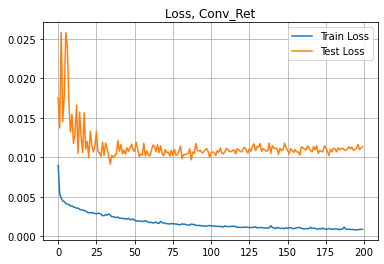

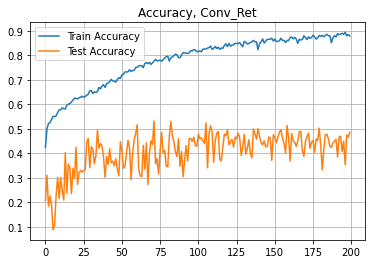

In [ ]:
train_set = ConvDataset.ConvDataset(train_dict, window_size=window_size)
valid_set = ConvDataset.ConvDataset(test_dict, window_size=window_size)
train_loader = DataLoader(train_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=ConvDataset.ConvDataset.custom_collate_fn)
valid_loader = DataLoader(valid_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=ConvDataset.ConvDataset.custom_collate_fn)

model = ConvModel.ConvModel(feature_size=input_size)
criterion = nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=Hypers.Config.learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainer = Trainer.Trainer(model=model,
                          criterion=criterion,
                          optimizer=optimizer,
                          device=device,
                          train_loader=train_loader,
                          valid_loader=valid_loader,
                          model_type=model_type)
train_loss, train_accuracy, valid_loss, valid_accuracy = trainer.train_loop()
utils.plot_graph(train_loss, train_accuracy, valid_loss, valid_accuracy, identifier=f"{model_type}_{suffix}")

# Infer

In [ ]:
import Inferencer
importlib.reload(Inferencer)

<module 'Inferencer' from '/Users/Ryo/Desktop/UCLA/PNC_Capstone/Inferencer.py'>

In [ ]:
import RegressionDataset
importlib.reload(RegressionDataset)
import RegressionModel
importlib.reload(RegressionModel)

test_loader = DataLoader(valid_set, batch_size=Hypers.Config.batch_size, shuffle=False, collate_fn=RegressionDataset.RegressionDataset.custom_collate_fn)
inferencer = Inferencer.Inferencer(model=model, test_loader=test_loader, device=device)
predictions, turths, accuracy, diff_counter = inferencer.infer()

In [ ]:
nums = 10
print(predictions[:nums])
print(turths[:nums])

tensor([5., 5., 4., 4., 4., 4., 4., 4., 3., 4.])
tensor([4., 4., 4., 4., 4., 4., 4., 4., 4., 4.])


In [ ]:
print(diff_counter)

Counter({0.0: 666, 1.0: 549, 2.0: 109, 5.0: 25, 4.0: 8, 3.0: 7, 6.0: 5})


In [ ]:
total_count = sum(diff_counter.values())
print(f"{total_count=}")

total_count=1369


In [ ]:
accumulated_count = []

for i in range(0, 33):
    count = diff_counter[i]
    if i==0:
        accumulated_count.append(count)
        continue
    accumulated_count.append(accumulated_count[-1]+count)

accumulated_accuracy = [i/total_count for i in accumulated_count]
accumulated_accuracy[:5]

[0.4864864864864865,
 0.887509130752374,
 0.9671292914536158,
 0.9722425127830533,
 0.9780861943024105]

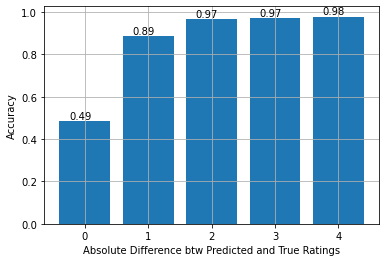

In [ ]:
import matplotlib.pyplot as plt

plt.bar(range(0,5), accumulated_accuracy[:5])
for i, v in enumerate(accumulated_accuracy[:5]):
    plt.text(i - 0.25, v + 0.01, str(round(v, 2)))
plt.xlabel("Absolute Difference btw Predicted and True Ratings")
plt.ylabel("Accuracy")
plt.grid()
plt.show()